In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_legendre
from scipy.interpolate import interp1d
from tqdm import tqdm

from constants import BETA4, MU
from interaction import potential
from counterterm import local_LO_counterterm
from mottmassey import mm_potential

gr = 4/3
h = 3

plt.style.use('science')

In [2]:
lo_rg_flow = np.loadtxt('rgflow_local_lo_a0_fix_hp_n_14_coord_ir_corrected.txt')
nlo_rg_flow = np.loadtxt('rgflow_local_nlo_a0_B6_fix_coord_hp_n_14_coord_ir_corrected.txt')

In [3]:
Delta = 5*np.pi

def find_minus_to_plus(x):
    n = x.size
    indices = []
    for i in range(n-1):
        if np.sign(x[i]) == -1 and  np.sign(x[i+1]) == 1:
            indices.append(i+1)
    return indices

def shift(x, add_pi=False):
    xp = x.copy()
    indices = find_minus_to_plus(xp)
    i = 0
    s = 0
    for j in indices:
#         print(i, j, s)
        xp[i:j] -= s*np.pi
        s += 1
        i = j
    xp[j:] -= s*np.pi
    return xp + (Delta if add_pi else 0)


class PhaseShifts:
    '''
    Container for phase shift related data.
    '''
    def __init__(self,
        rg_flow : np.array,
        filename : str,
        upper_bound : float,
        lower_bound : float = 0,
        complex : bool = False
    ):
        self.rg_flow = rg_flow.copy()
        self.filename = filename
        self.ub = upper_bound
        self.lb = lower_bound
        
        ii = np.intersect1d(
            np.where(BETA4/self.rg_flow[:, 0] > self.lb)[0],
            np.where(BETA4/self.rg_flow[:, 0] < self.ub)[0]
        )
            
        self.Rs = self.rg_flow[ii, 0]
        self.gs = self.rg_flow[ii, 1:]
        
        if complex:
            self.data = np.loadtxt(self.filename, dtype=np.complex128).real
        else:
            self.data = np.loadtxt(self.filename)
            
        self.momenta = self.data[:, 0]
        self.x = (self.momenta*BETA4)**2
        self.deltas = self.data[:, ii+1].T
        self.deltas_smooth = np.array([shift(row) for row in self.deltas])
        self.deltas_shifted = np.array([shift(row, add_pi=True) for row in self.deltas])
        
        self.deltas_f = interp1d(self.momenta, self.deltas_smooth[-1], kind='cubic', fill_value='extrapolate')
        self.deltas_f_shifted = lambda k: self.deltas_f(k) + Delta

In [4]:
lo = PhaseShifts(lo_rg_flow, 'phase_shifts_lo_wide_dense_hp_n_14_coord_ir_corrected.txt', 70)
# nlo = PhaseShifts(nlo_rg_flow, 'phase_shifts_nlo_wide_dense_hp_n_14_coord2_ir_corrected.txt', 70)
nlo = PhaseShifts(nlo_rg_flow, 'phase_shifts_nlo_hp_n_14_coord_ir_corrected.txt', 70)
nlop = PhaseShifts(nlo_rg_flow, 'phase_shifts_nlo_pert1_wide_dense_hp_n_14_true_coord_ir_corrected.txt', 70,
                   complex=True)
nlop_low = PhaseShifts(nlo_rg_flow, 
                       'phase_shifts_nlo_pert1_wide_dense_hp_n_14_true_coord_ir_corrected_low_momenta.txt', 70,
                       complex=True)
# nlop = PhaseShifts(nlo_rg_flow, 'phase_shifts_nlo_pert1_wide_dense_hp_n_14_coord_ir_corrected_quad.txt', 70,
#                   complex=True)

In [5]:
mm = np.loadtxt('phase_shifts_mott_massey_wide_dense_coord_ir_corrected.txt')[:-1, :]
ks_mm = mm[:, 0]
deltas_mm = mm[:, 1]
deltas_mm_smooth = shift(deltas_mm)
deltas_mm_shifted = deltas_mm_smooth + Delta

flambaum = np.loadtxt('flambaum_deltas_wide_dense.txt')
ks_flambaum = flambaum[:, 0]
deltas_flambaum = flambaum[:, 1:].T
deltas_flambaum_shifted = deltas_flambaum + Delta

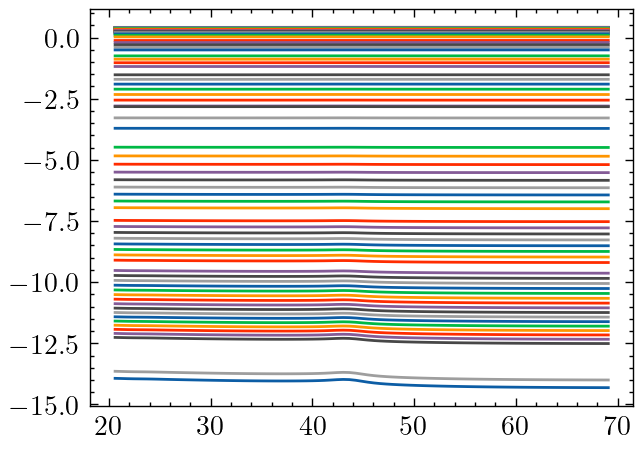

In [6]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

for row in lo.deltas_smooth.T:
    ax.plot(BETA4 / lo.Rs, row)

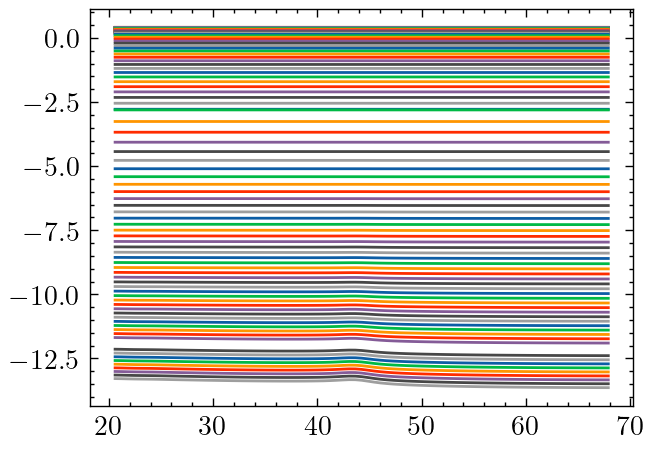

In [7]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

for row in nlop.deltas_smooth.T:
    ax.plot(BETA4/nlop.Rs, row)

In [8]:
nlop.deltas_smooth.shape

(79, 98)

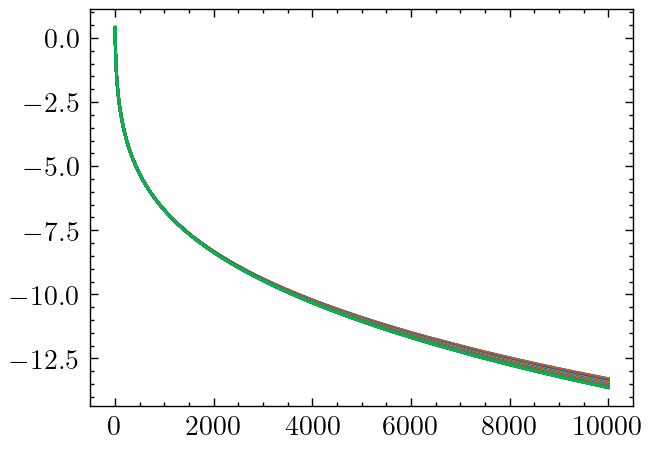

In [9]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

for row in nlop.deltas_smooth:
    ax.plot((nlop.momenta*BETA4)**2, row)

Text(0, 0.5, '$\\delta$')

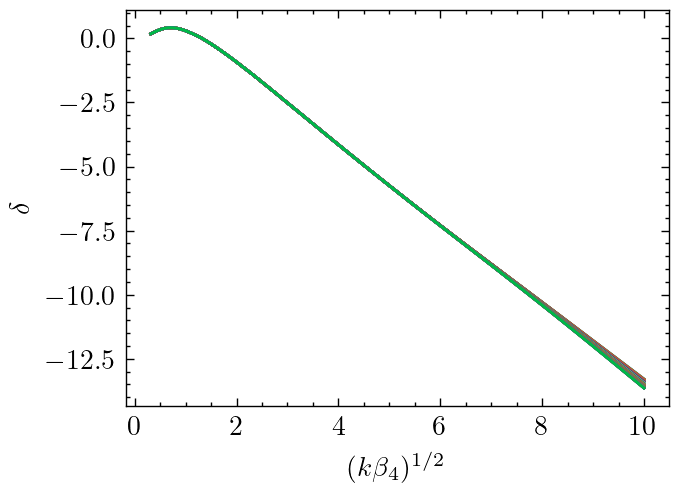

In [10]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

for row in nlop.deltas_smooth:
    ax.plot((nlop.momenta*BETA4)**0.5, row)

ax.set_xlabel(r'$(k\beta_4)^{1/2}$')
ax.set_ylabel(r'$\delta$')

## Compare NLO and Perturbative NLO

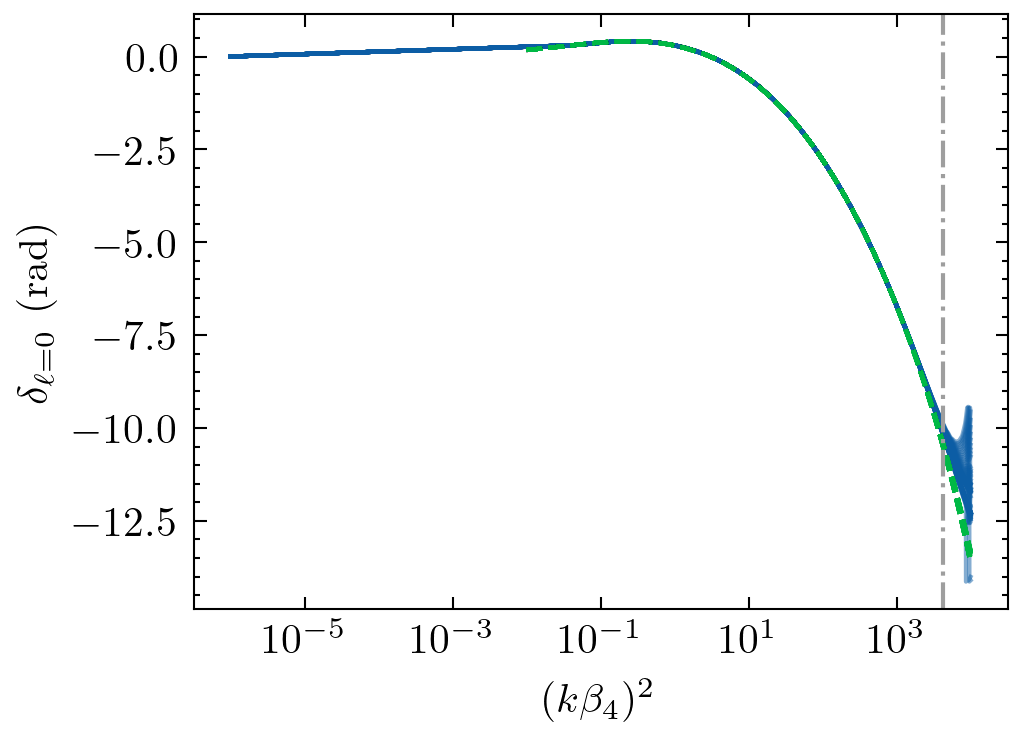

In [11]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_facecolor('white')

# NLO
for row in nlo.deltas_smooth:
    ax.plot(nlo.x, row, color='C0', alpha=0.5)

# Perturbative NLO
for row in nlop.deltas_smooth:
    ax.plot(nlop.x, row, color='C1', alpha=0.5, linestyle='--')

ax.set_xscale('log')
ax.axvline((BETA4*2)**2, color='C6', linestyle='-.')

ax.set_xlabel(r'$(k\beta_4)^2$')
ax.set_ylabel(r'$\delta_{\ell=0}$ (rad)');

In [12]:
def draw_smooth_bands(x, y_low, y_high, ax, color):
    f_low = interp1d(x, y_low, kind='cubic')
    f_high = interp1d(x, y_high, kind='cubic')
    
    xp = np.linspace(x[0], x[-1], 10*x.size)
    ax.fill_between(xp, f_low(xp), f_high(xp), color=color, alpha=0.5)

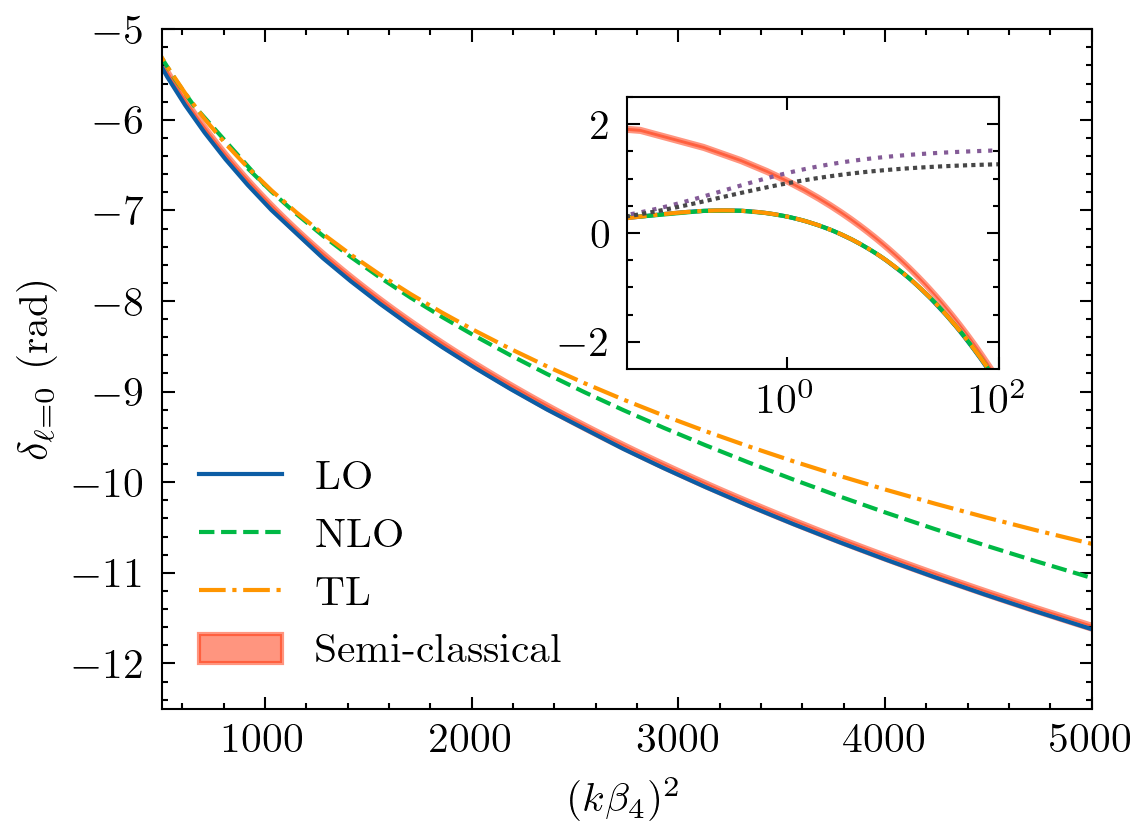

In [41]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=300)
fig.patch.set_facecolor('white')

# LO results
# y = (deltas_lo[-1, :]-Delta)
# sig = y * ks_lo/2
# ax.fill_between((ks_lo*const.BETA4)**2, y-sig, y+sig, color='C0', label='LO', alpha=0.5)
ax.plot(lo.x, lo.deltas_smooth[-1], color='C0', label='LO')

# NL0
# ax.plot(nlo.x, nlo.deltas_smooth[-1], color='C1', linestyle='--', label='NLO')

# NLOp results
# y = (deltas_nlo_pert1[-1, :]-Delta)
# sig = y * (ks_nlop)**2 / 2
# ax.fill_between((ks_nlop*const.BETA4)**2, y-sig, y+sig, color='C1', label='NLO', alpha=0.5)
ii = np.where(nlop.x > 900)[0]
ax.plot(nlop.x[ii], nlop.deltas_smooth[-1, ii], color='C1', label='NLO', linestyle='--')
ax.plot(nlop_low.x, nlop_low.deltas_smooth[-1], color='C1', linestyle='--')


## Mott-Massey results
ax.plot((ks_mm*BETA4)**2, deltas_mm_smooth, color='C2', linestyle='-.', label='TL')

## Flambaum results
ax.fill_between((ks_flambaum*BETA4)**2, deltas_flambaum[0, :], deltas_flambaum[2, :], color='C3', alpha=0.5,
                label='Semi-classical')

# ax.set_xscale('log')
ax.set_xlim([500, 5000])
ax.set_ylim([-12.5, -5])
ax.legend(loc='lower left')
ax.set_xlabel(r'$(k\beta_4)^2$')
ax.set_ylabel(r'$\delta_{\ell=0}$ (rad)');

#
# Inset
#

axin = ax.inset_axes([0.5, 0.5, 0.4, 0.4])

axin.plot(lo.x, lo.deltas_smooth[-1], color='C0')
axin.plot(nlo.x, nlo.deltas_smooth[-1], color='C1', linestyle='-')
# axin.plot(nlop.x, nlop.deltas_smooth[-1], color='C1', linestyle='-')

axin.plot((ks_mm*BETA4)**2, deltas_mm_smooth, color='C2', linestyle='-.')
axin.fill_between((ks_flambaum*BETA4)**2, deltas_flambaum[0, :], deltas_flambaum[2, :],
                  color='C3', alpha=0.5)
axin.set_xlim([0.03, 100])
axin.set_ylim([-2.5, 2.5])
axin.set_xscale('log')

# ERE
A0_TL = -65
axin.plot((ks_mm*BETA4)**2, np.arctan(-(A0_TL*ks_mm)), color='C4', linestyle=':')
axin.plot((ks_mm*BETA4)**2, np.arctan(ks_mm / (-1/A0_TL + (np.pi*BETA4**2/(3*A0_TL**2))*ks_mm)),
          color='C5', linestyle=(0, (1, 1)))

# ax.indicate_inset_zoom(axin, edgecolor="black")

plt.savefig('figures/deltas.pdf')

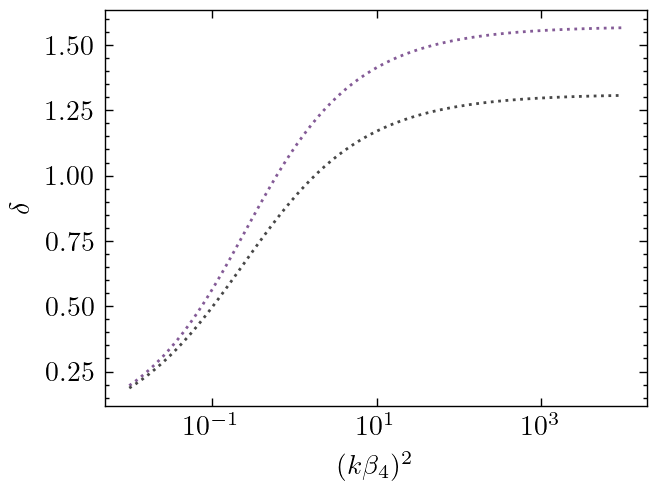

In [42]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot((ks_mm*BETA4)**2, np.arctan(-(A0_TL*ks_mm)), color='C4', linestyle='dotted')
ax.plot((ks_mm*BETA4)**2, np.arctan(ks_mm / (-1/A0_TL + (np.pi*BETA4**2/(3*A0_TL**2))*ks_mm)),
          color='C5', linestyle='dotted')

ax.set_xscale('log')
ax.set_xlabel(r'$(k\beta_4)^2$')
ax.set_ylabel(r'$\delta$');

In [43]:
delta_f_mm = interp1d(ks_mm, deltas_mm_smooth, kind='cubic', fill_value='extrapolate')
delta_f_flambaum = interp1d(ks_flambaum, deltas_flambaum[1, :], kind='cubic', fill_value='extrapolate')

In [44]:
deltas_flambaum.shape

(3, 500)

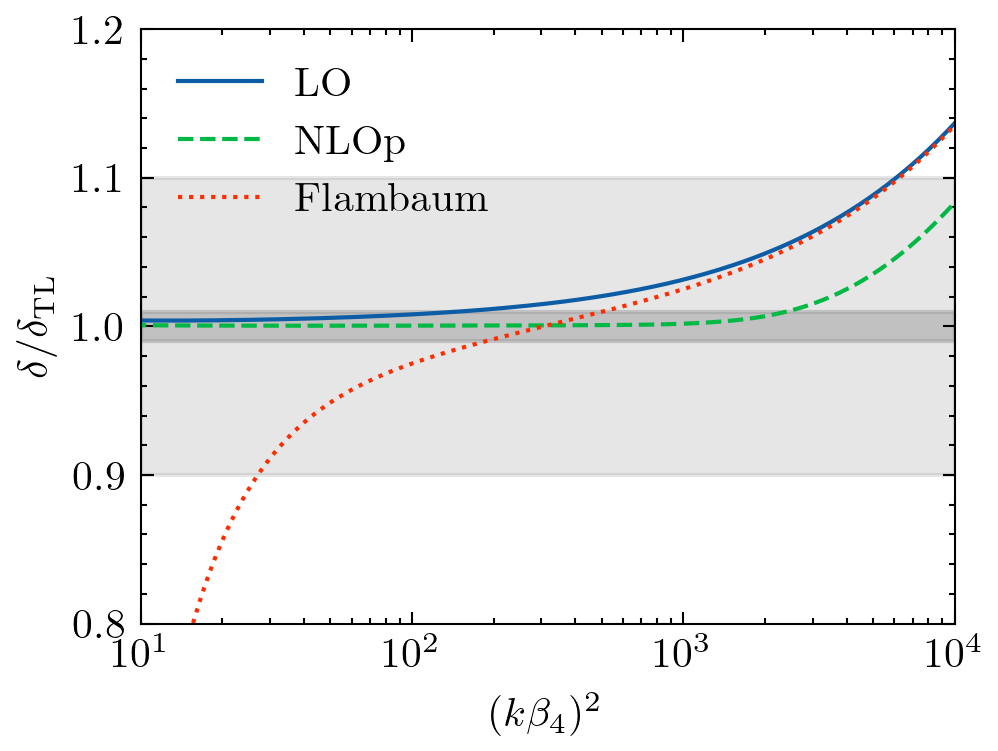

In [45]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_facecolor('white')

x = np.logspace(
    np.log10(lo.momenta[0]),
    np.log10(lo.momenta[-1]),
    500
)

low = np.where((x*BETA4)**2 < 1000)
high = np.where((x*BETA4)**2 > 1000)

# LO
ax.plot((x*BETA4)**2, lo.deltas_f(x)/delta_f_mm(x), linestyle='-', color='C0', label='LO')

# NLO
# ax.plot((x*BETA4)**2, nlo.deltas_f(x)/delta_f_mm(x), linestyle='--', color='C1', label='NLO')

# NLOp
ax.plot((x[low]*BETA4)**2, nlop_low.deltas_f(x[low])/delta_f_mm(x[low]), linestyle='--', color='C1', label='NLOp')
ax.plot((x[high]*BETA4)**2, nlop.deltas_f(x[high])/delta_f_mm(x[high]), linestyle='--', color='C1')

# Flambaum
ax.plot((x*BETA4)**2, delta_f_flambaum(x)/delta_f_mm(x), linestyle='dotted', color='C3', label='Flambaum')

ax.axhspan(0.99, 1.01, color='C6', alpha=0.5)
ax.axhspan(0.9, 1.1, color='C6', alpha=0.25)

ax.legend()
ax.set_xscale('log')
ax.set_xlim([10, 10000])
ax.set_ylim([0.8, 1.2])
ax.set_ylabel(r'$\delta/\delta_{\rm TL}$')
ax.set_xlabel(r'$(k\beta_4)^2$');

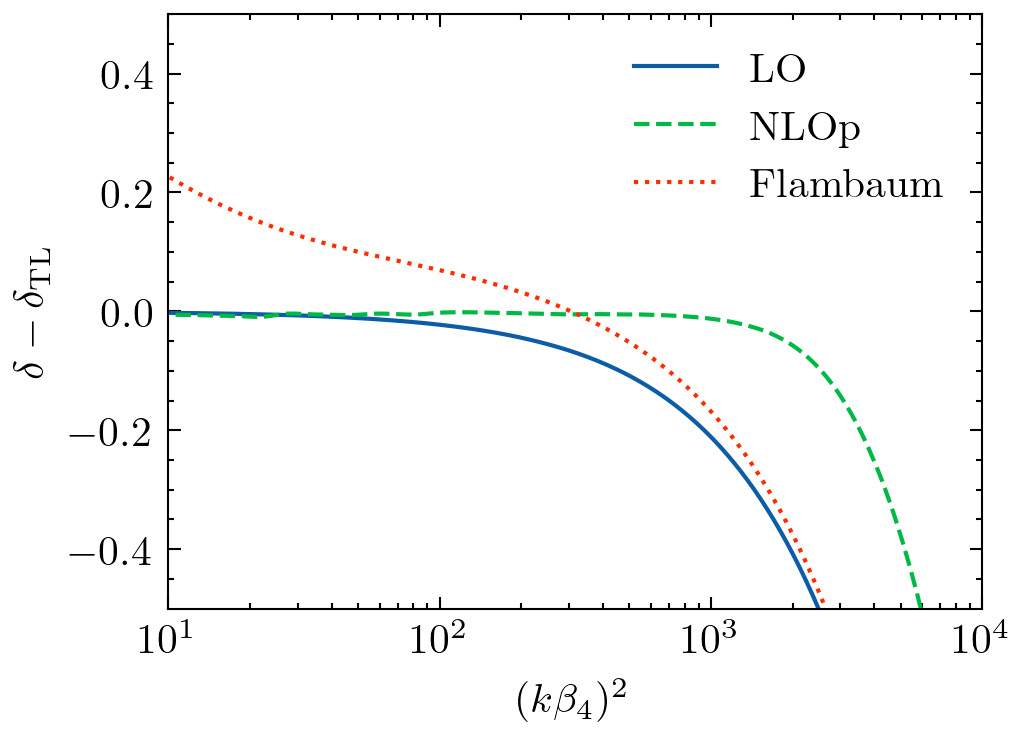

In [46]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_facecolor('white')

x = np.logspace(
    np.log10(lo.momenta[0]),
    np.log10(lo.momenta[-1]),
    500
)

# LO
ax.plot((x*BETA4)**2, lo.deltas_f(x) - delta_f_mm(x), linestyle='-', color='C0', label='LO')
# NLO
# ax.plot((x*BETA4)**2, nlo.deltas_f(x) - delta_f_mm(x), linestyle='--', color='C1', label='NLO')
# NLOp
ax.plot((x*BETA4)**2, nlop.deltas_f(x) - delta_f_mm(x), linestyle='--', color='C1', label='NLOp')
# Flambaum
ax.plot((x*BETA4)**2, delta_f_flambaum(x) - delta_f_mm(x), linestyle='dotted', color='C3', label='Flambaum')

ax.legend()
ax.set_xscale('log')
ax.set_xlim([10, 10000])
ax.set_ylim([-0.5, 0.5])
ax.set_ylabel(r'$\delta - \delta_{\rm TL}$')
ax.set_xlabel(r'$(k\beta_4)^2$');

In [47]:
mm = np.loadtxt('spectrum_Mott_Massey_hp_coord.txt')
b2_mm = np.abs(mm)
gamma_mm = np.sqrt(2*MU*b2_mm)

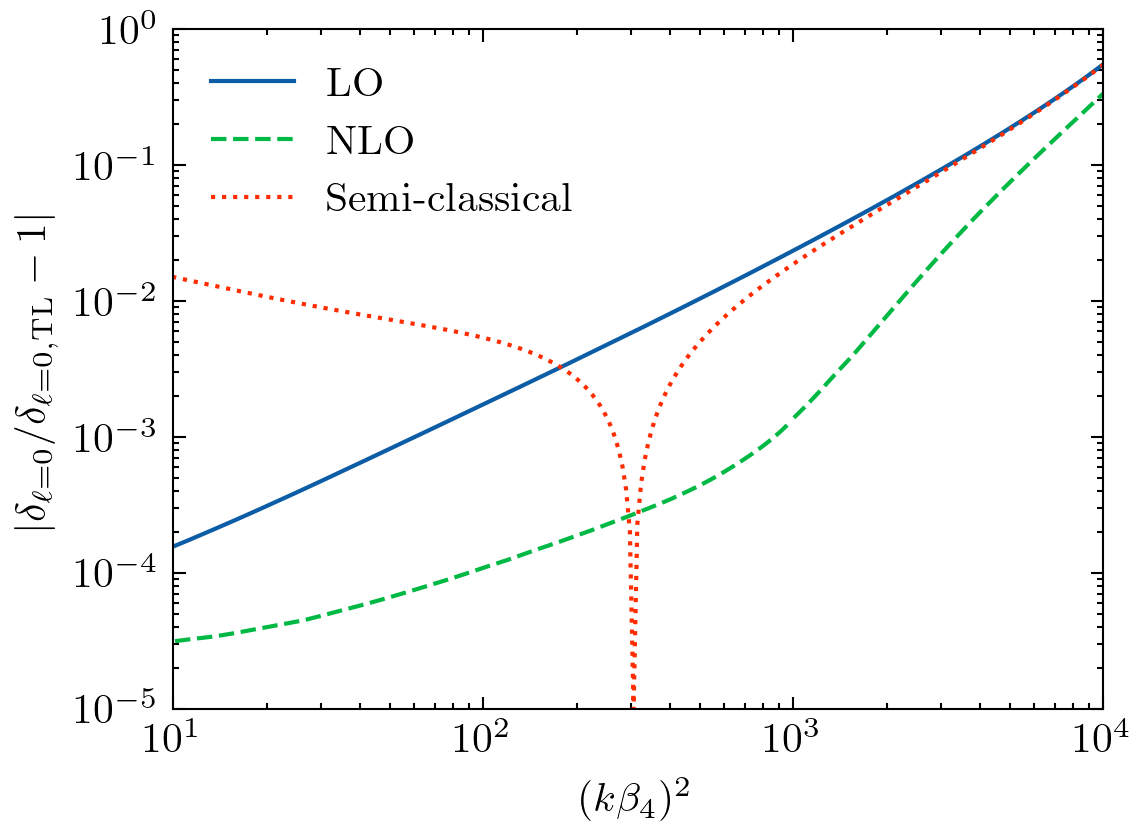

In [48]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=300)
fig.patch.set_facecolor('white')

# LO results
ax.plot((x*BETA4)**2, np.abs(lo.deltas_f_shifted(x)/(delta_f_mm(x) + Delta) - 1),
        color='C0', label='LO', linestyle='-')

# NLO
# ax.plot((x*BETA4)**2, np.abs(nlo.deltas_f_shifted(x)/(delta_f_mm(x) + Delta) - 1), color='C1', label='NLO', linestyle='--')

# NLOp (low momenta)
ax.plot((x[low]*BETA4)**2, np.abs(nlop_low.deltas_f_shifted(x[low])/(delta_f_mm(x[low]) + Delta) - 1), 
        color='C1', label='NLO', linestyle='--')

# NLOp
ax.plot((x[high]*BETA4)**2, np.abs(nlop.deltas_f_shifted(x[high])/(delta_f_mm(x[high]) + Delta) - 1), 
        color='C1', linestyle='--')

# Flambaum
ax.plot((x*BETA4)**2, np.abs((delta_f_flambaum(x) + Delta)/(delta_f_mm(x) + Delta) - 1),
        linestyle='dotted', color='C3', label='Semi-classical')

# label = r'MM'
# for gamma in gamma_mm:
#     ax.axvline((BETA4*gamma)**2, color='C6', linestyle='--', label=label)
#     label = None
    
# ax.axvspan(0, 800, color='C5', alpha=0.1)
ax.legend()
ax.set_ylim([1e-5, 1])
ax.set_xlim([10, 10000])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$(k\beta_4)^2$')
ax.set_ylabel(r'$|\delta_{\ell=0}/\delta_{\ell=0,{\rm TL}}-1|$');

plt.savefig('figures/deltas_relative.pdf')